# Neural Spline Flows

Instead of Affine transformations ( for Coupeling Flows) and additive transformations on the case of Autoregressive flows we use monotonic rational-quadratic transforms (via monotonic rational-quadratic splines)

## monotonic rational-quadratic transforms



In [ ]:
import torch
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from src.utils import get_two_moons_data
from src.models.real_nvp_spline import RealNVPSpline
from src.flows.spline.arqs import ARQS
from src.flows.flow.sequential_flow import SequentialFlow


data_dim = 2
n_samples = 20000
n_layers = 8
hidden_dim = 128
learning_rate = 1e-4
n_epochs = 200
batch_size = 1024

device = torch.device('cpu') #torch.device('mps' if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load Data ---
data = get_two_moons_data(n_samples=n_samples).to(device)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
data_min = data.min(dim=0).values 
data_max = data.max(dim=0).values 
# --- 3. Initialize Model, Base Distribution, and Optimizer ---
#model = RealNVPSpline(data_dim=data_dim, n_layers=n_layers, hidden_dim=hidden_dim).to(device)
model = SequentialFlow([ARQS(dim=data_dim, num_bins=8, hidden_dim=hidden_dim, layers=2, data_min=data_min, data_max=data_max) for _ in range(n_layers)]).to(device)
# Base distribution: a standard 2D Gaussian
# Calculate the mean (center) along each dimension
center = torch.mean(data, dim=0)

# Create the centered Gaussian distribution
base_distribution = dist.MultivariateNormal(
    loc=center,  # Center the Gaussian here
    covariance_matrix=torch.eye(data_dim).to(device)
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',    # Reduce on loss stagnation
    factor=0.1,    # Reduce LR by a factor of 10
    patience=10,   # Wait 10 epochs before reducing
)
# --- 4. Training Loop ---
model.train()
print("Starting training...")
for epoch in range(n_epochs):
    total_loss = 0
    for i, x_batch in enumerate(data_loader):
        optimizer.zero_grad()

        # Forward pass and loss calculation
        z, log_det_J_inv = model.inverse(x_batch)
        log_prob_z = base_distribution.log_prob(z)
        log_likelihood = log_prob_z + log_det_J_inv
        loss = -torch.mean(log_likelihood)

        # Backward pass
        loss.backward()


        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()
        
        total_loss += loss.item()
    scheduler.step(loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(data_loader):.4f}")

print("Training finished.")


Using device: cpu
Starting training...


/Users/tom/workspace/github.com/itxtx/normalizing-flows-study/notebooks/../src/flows/spline/rational_quadratic_spline.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  bin_idx = torch.searchsorted(boundaries, inputs.unsqueeze(-1), right=True) - 1


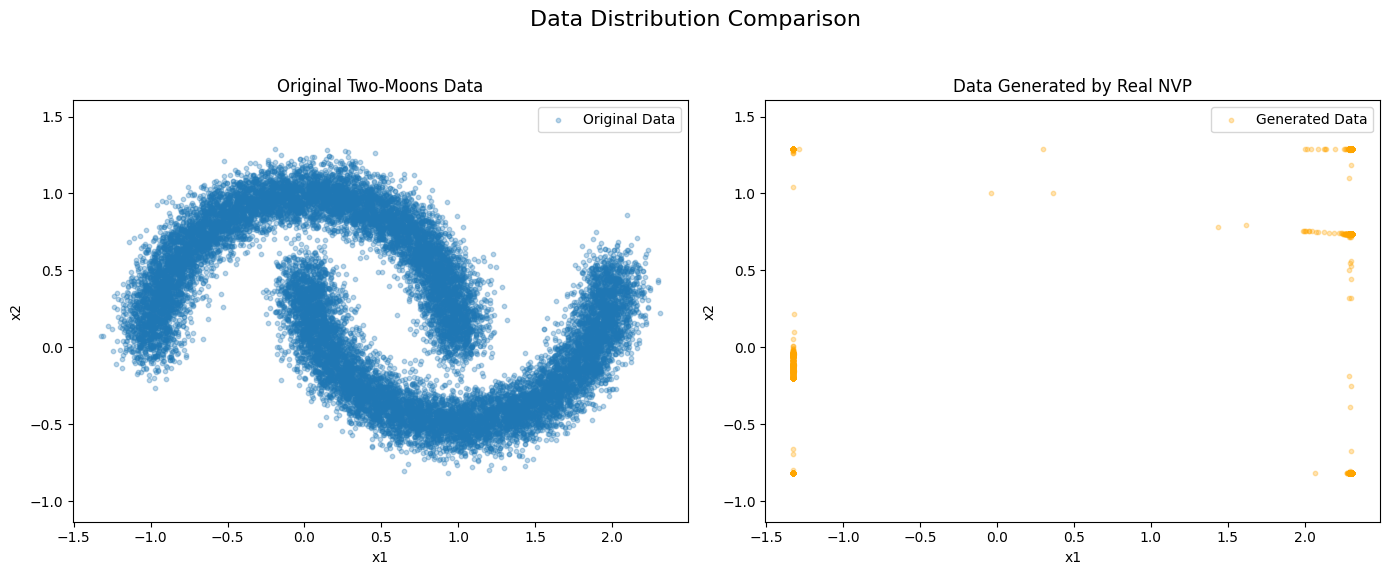

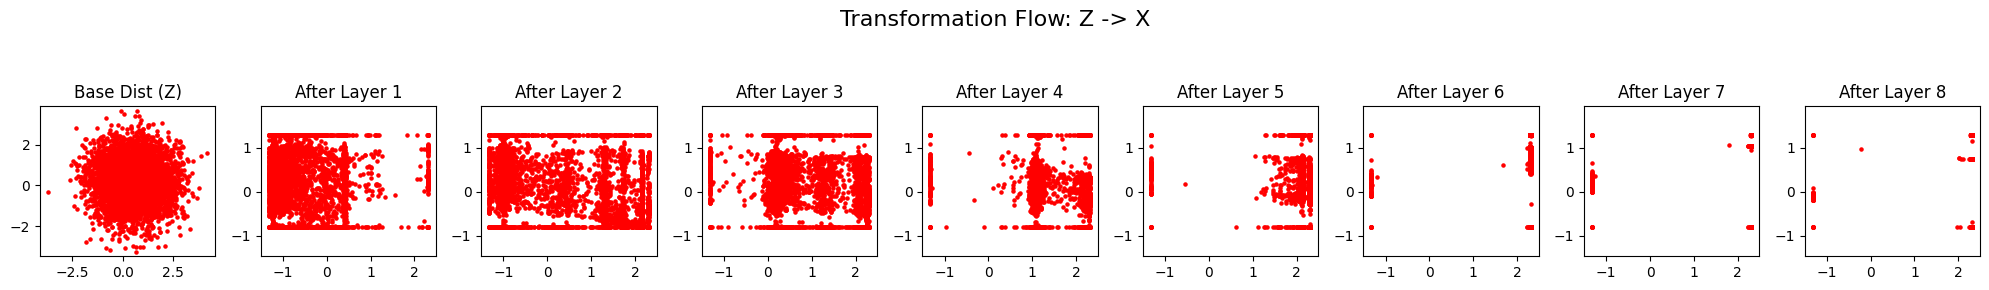

In [ ]:
# --- 5. Visualization ---
model.eval()
with torch.no_grad():
    # a) Plot generated samples vs. original data
    plt.figure(figsize=(14, 6))
    
    # Original Data
    plt.subplot(1, 2, 1)
    plt.scatter(data.cpu()[:, 0], data.cpu()[:, 1], s=10, alpha=0.3, label='Original Data')
    plt.title('Original Two-Moons Data')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')

    # Generated Data
    plt.subplot(1, 2, 2)
    # Sample from base distribution
    z_samples = base_distribution.sample((n_samples,))
    # Transform to data space
    x_generated, _ = model.forward(z_samples)
    x_generated = x_generated.cpu().numpy()
    plt.scatter(x_generated[:, 0], x_generated[:, 1], s=10, alpha=0.3, c='orange', label='Generated Data')
    plt.title('Data Generated by Real NVP')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.axis('equal')
    
    plt.suptitle('Data Distribution Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # b) Recreate Figure 18.3: The "flow"
    fig, axes = plt.subplots(1, n_layers + 1, figsize=(20, 3))
    
    # Start with base distribution samples
    z_grid = base_distribution.sample((5000,))
    
    # Plot initial distribution
    axes[0].scatter(z_grid.cpu()[:, 0], z_grid.cpu()[:, 1], s=5, c='r')
    axes[0].set_title("Base Dist (Z)")
    axes[0].axis('equal')
    
    x_flow = z_grid
    layers = getattr(model, 'layers', getattr(model, 'flows', None))
    for i, layer in enumerate(layers):
        x_flow, _ = layer.forward(x_flow)
        axes[i + 1].scatter(x_flow.cpu()[:, 0], x_flow.cpu()[:, 1], s=5, c='r')
        axes[i + 1].set_title(f"After Layer {i+1}")
        axes[i + 1].axis('equal')
        
    fig.suptitle('Transformation Flow: Z -> X', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()